# <font color='red' face='Times New Roman' size=15>**A Machine Learning Model to Predict the frequency of delayed neurologic sequelae in carbon monoxide poisoning patients**</font>

## **以下是文章中 DNS 预测模型的一个示例，由于笔者水平有限，建模过程中难免存在瑕疵，勿怪**

### 构建 DNS 预测模型流程如下：

#### 导入需要的库和函数，各个 Python 包（除 pickle 外）的版本如下：
|Package|Version|
|:---:|:---:|
|bayesian-optimization|1.4.3|
|imbalanced-learn|0.12.3|
|lightgbm|4.4.0|
|matplotlib|3.9.0|
|numpy|1.26.4|
|pandas|2.0.0|
|scikit-learn|1.5.0|
|seaborn|0.13.2|
|shap|0.45.1|
|xgboost|2.1.0|

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.pipeline import make_pipeline
import shap
import pickle
from modeling import *  ##  自定义函数

#### 导入文件，划分特征集和标签集；对性别变量独热编码（因为我们想知道到底是哪个性别有影响）

In [13]:
data, X, y = input_data('CO中毒.xlsx')

gender = pd.get_dummies(data['Gender'], dtype=int)
X.drop(['Gender'], axis=1, inplace=True)
X = pd.concat([gender, X], axis=1)

#### 分层采样划分训练集和测试集，对非二元特征标准化

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

X_train, X_test = scale_num_feature(X, X_train, X_test)

#### 逻辑斯蒂回归选择 10 个重要特征

In [15]:
# 使用逻辑斯蒂回归模型来选择特征，其中 liblinear 适用于小数据集，而 L1 正则化可以有效减少特征数量
model = LogisticRegression(solver='liblinear', penalty='l1', random_state=0)
num_features = 10

X_train, X_test, features_selected = feature_selection(model, num_features, X_train, y_train, X_test)

print(f"We select {len(features_selected)} features as follows:\n{features_selected}")

We select 10 features as follows:
     Features
0      female
1        COPD
2         GCS
3        HBOT
4        L(%)
5        APTT
6         AST
7  creatinine
8        eGFR
9         GLU


#### 使用不同的过采样策略来平衡数据集，并定义管道；我们这里使用SMOTE过采样方法作为演示。

Decision Tree's results of 10-fold cross-validation are as follows: 
 [0.65517241 0.72413793 0.75862069 0.82758621 0.65517241 0.79310345
 0.89655172 0.82758621 0.75       0.78571429] 

Decision Tree's mean accuracy of 10-fold cross-validation is 0.767
Decision Tree's Matthews Correlation Coefficient is 0.472 

Decision Tree's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82        51
           1       0.58      0.71      0.64        21

    accuracy                           0.76        72
   macro avg       0.72      0.75      0.73        72
weighted avg       0.78      0.76      0.77        72



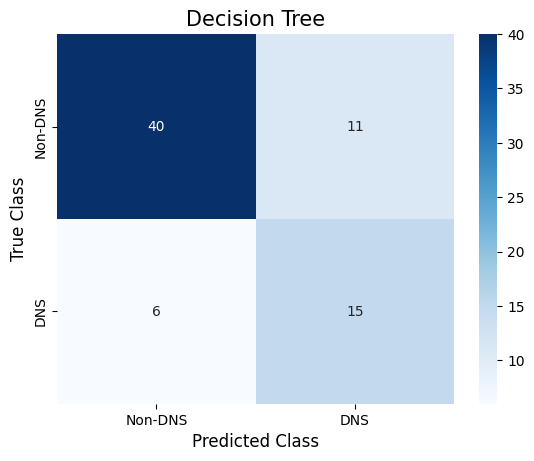

Random Forest's results of 10-fold cross-validation are as follows: 
 [0.82758621 0.72413793 0.86206897 0.86206897 0.79310345 0.93103448
 0.79310345 0.82758621 0.89285714 0.82142857] 

Random Forest's mean accuracy of 10-fold cross-validation is 0.833
Random Forest's Matthews Correlation Coefficient is 0.609 

Random Forest's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        51
           1       0.70      0.76      0.73        21

    accuracy                           0.83        72
   macro avg       0.80      0.81      0.80        72
weighted avg       0.84      0.83      0.84        72



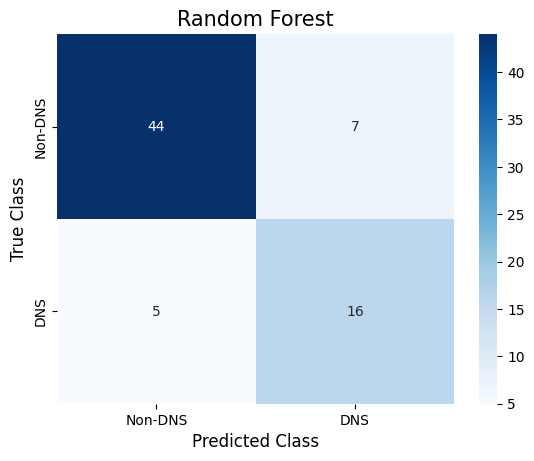

Extreme Gradient Boosting's results of 10-fold cross-validation are as follows: 
 [0.89655172 0.75862069 0.82758621 0.82758621 0.79310345 0.89655172
 0.82758621 0.86206897 0.89285714 0.78571429] 

Extreme Gradient Boosting's mean accuracy of 10-fold cross-validation is 0.837
Extreme Gradient Boosting's Matthews Correlation Coefficient is 0.491 

Extreme Gradient Boosting's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        51
           1       0.57      0.76      0.65        21

    accuracy                           0.76        72
   macro avg       0.73      0.76      0.74        72
weighted avg       0.79      0.76      0.77        72



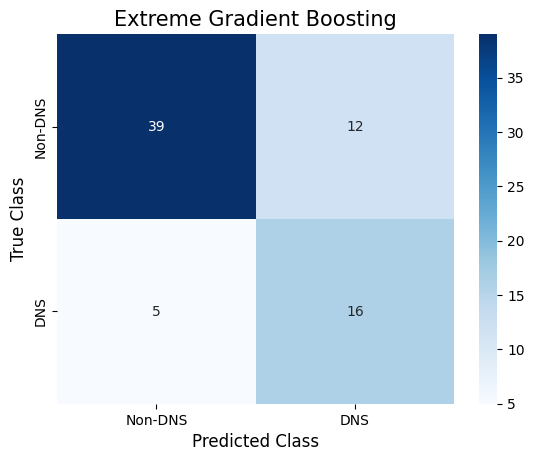

Light Gradient Boosting Machine's results of 10-fold cross-validation are as follows: 
 [0.86206897 0.79310345 0.86206897 0.79310345 0.72413793 0.89655172
 0.86206897 0.89655172 0.92857143 0.82142857] 

Light Gradient Boosting Machine's mean accuracy of 10-fold cross-validation is 0.844
Light Gradient Boosting Machine's Matthews Correlation Coefficient is 0.519 

Light Gradient Boosting Machine's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        51
           1       0.62      0.71      0.67        21

    accuracy                           0.79        72
   macro avg       0.75      0.77      0.76        72
weighted avg       0.80      0.79      0.80        72



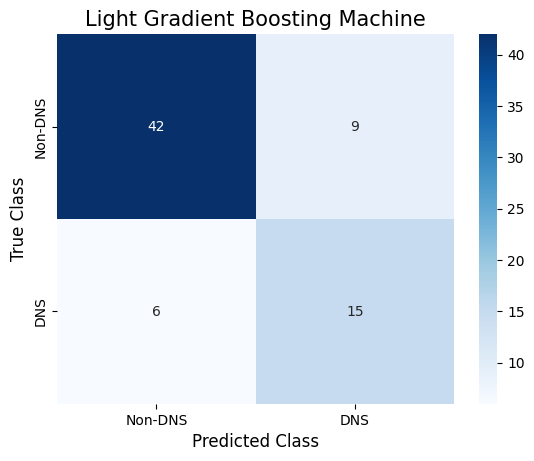

In [16]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)  ##  10 折分层交叉验证

oversample_method = SMOTE(random_state=0)  ##  SMOTE 过采样
# oversample_method = ADASYN(random_state=0)  ##  ADASYN 过采样
# oversample_method = RandomOverSampler(random_state=0)  ##  随机过采样

models = [
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    XGBClassifier(seed=0),
    LGBMClassifier(verbose=-1, random_state=0)
]

modelnames = [
    'Decision Tree',
    'Random Forest',
    'Extreme Gradient Boosting',
    'Light Gradient Boosting Machine'
]

pipelines = [make_pipeline(oversample_method, model) for model in models]

for ppl, modelname in zip(pipelines, modelnames):  ##  先 train 一波看看效果
    
    print('='*75)
    evaluate_model(ppl, X_train, y_train, X_test, y_test, kf, modelname)

# 对于 No Treatment 组，省略过采样和管道操作
# for model, modelname in zip(models, modelnames):
    
#     print('='*75)
#     evaluate_model(model, X_train, y_train, X_test, y_test, kf)

#### Decision Tree，贝叶斯优化调参

In [17]:
def black_box_function1(max_depth, max_features, min_samples_split, min_samples_leaf):
    
    model = DecisionTreeClassifier(
        max_depth=int(max_depth),
        max_features=int(max_features),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=0
    )

    pipeline = make_pipeline(oversample_method, model)
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=kf)  ##  我们使用默认的 accuracy 作为评估指标，事实上使用 recall 也许会更好

    return cv_score.mean()

pbounds1 = {
    'max_depth':(1, 10),
    'max_features':(1, 10),
    'min_samples_split':(2, 50),
    'min_samples_leaf':(1, 50)
}

optimizer1 = BayesianOptimization(
    f=black_box_function1,
    pbounds=pbounds1,
    random_state=0,
)

optimizer1.maximize(init_points=25, n_iter=75)

best_params1 = optimizer1.max['params']
best_params1['max_depth'] = int(best_params1['max_depth'])
best_params1['max_features'] = int(best_params1['max_features'])
best_params1['min_samples_split'] = int(best_params1['min_samples_split'])
best_params1['min_samples_leaf'] = int(best_params1['min_samples_leaf'])

print("Optimized parameters:", optimizer1.max)
print(best_params1)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.8058    | 5.939     | 7.437     | 30.54     | 28.15     |
| 2         | 0.7814    | 4.813     | 6.813     | 22.44     | 44.81     |
| 3         | 0.7225    | 9.673     | 4.451     | 39.79     | 27.39     |
| 4         | 0.802     | 6.112     | 9.33      | 4.481     | 6.182     |
| 5         | 0.7433    | 1.182     | 8.494     | 39.13     | 43.76     |
| 6         | 0.7953    | 9.808     | 8.192     | 23.61     | 39.47     |
| 7         | 0.7297    | 2.064     | 6.759     | 8.024     | 47.34     |
| 8         | 0.7539    | 5.697     | 4.732     | 13.96     | 39.16     |
| 9         | 0.7639    | 5.105     | 6.116     | 1.921     | 31.65     |
| 10        | 0.7506    | 6.509     | 6.552     | 47.24     | 34.73     |
| 11        | 0.736     | 4.236     | 4.933     | 35.18     | 4.891     |
| 12        | 0.7777    | 7.001     | 

#### 评估性能

Decision Tree's results of 10-fold cross-validation are as follows: 
 [0.82758621 0.75862069 0.82758621 0.86206897 0.68965517 0.86206897
 0.75862069 0.79310345 0.85714286 0.82142857] 

Decision Tree's mean accuracy of 10-fold cross-validation is 0.806
Decision Tree's Matthews Correlation Coefficient is 0.491 

Decision Tree's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80        51
           1       0.55      0.81      0.65        21

    accuracy                           0.75        72
   macro avg       0.73      0.77      0.73        72
weighted avg       0.80      0.75      0.76        72



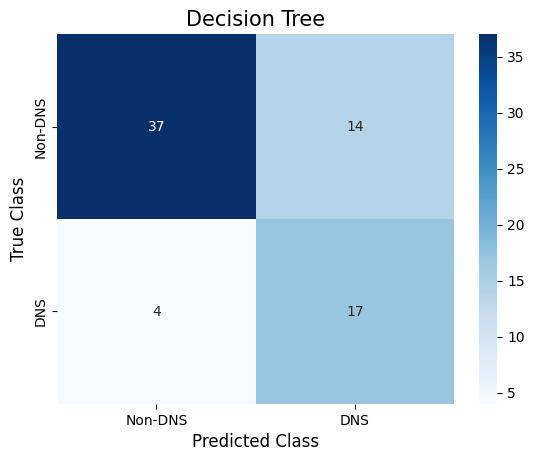

In [20]:
model_1 = DecisionTreeClassifier(
    max_depth=best_params1['max_depth'],
    max_features=best_params1['max_features'],
    min_samples_split=best_params1['min_samples_split'],
    min_samples_leaf=best_params1['min_samples_leaf'],
    random_state=0
)  ##  可以发现，超参数调整后，模型的召回率提升，即，能够更好的预测DNS样本（尽管以牺牲精确率为代价）

pipeline1 = make_pipeline(oversample_method, model_1)

evaluate_model(pipeline1, X_train, y_train, X_test, y_test, kf, 'Decision Tree')

#### Random Forest，贝叶斯优化调参

In [21]:
def black_box_function2(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=int(max_features),
        random_state=0
    )

    pipeline = make_pipeline(oversample_method, model)
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=kf)
    
    return cv_score.mean()

pbounds2 = {
    'n_estimators': (50, 500),
    'max_depth': (1, 10),
    'min_samples_split': (2, 50),
    'min_samples_leaf': (1, 50),
    'max_features': (1, 10)
}

optimizer2 = BayesianOptimization(
    f=black_box_function2,
    pbounds=pbounds2,
    verbose=2,
    random_state=0
)

optimizer2.maximize(init_points=25, n_iter=75)

best_params2 = optimizer2.max['params']
best_params2['n_estimators'] = int(best_params2['n_estimators'])
best_params2['max_depth'] = int(best_params2['max_depth'])
best_params2['min_samples_split'] = int(best_params2['min_samples_split'])
best_params2['min_samples_leaf'] = int(best_params2['min_samples_leaf'])
best_params2['max_features'] = int(best_params2['max_features'])

print("Optimized parameters:", optimizer2.max)
print(best_params2)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.8022    | 5.939     | 7.437     | 30.54     | 28.15     | 240.6     |
| 2         | 0.806     | 6.813     | 4.938     | 44.7      | 48.26     | 222.5     |
| 3         | 0.8059    | 8.126     | 5.76      | 28.83     | 46.43     | 81.97     |
| 4         | 0.7885    | 1.784     | 1.182     | 41.8      | 39.35     | 441.5     |
| 5         | 0.8025    | 9.808     | 8.192     | 23.61     | 39.47     | 103.2     |
| 6         | 0.8025    | 6.759     | 2.29      | 47.29     | 27.05     | 236.6     |
| 7         | 0.8164    | 3.381     | 7.968     | 23.35     | 29.28     | 58.46     |
| 8         | 0.8129    | 6.559     | 6.509     | 31.23     | 47.3      | 356.8     |
| 9         | 0.8058    | 4.236     | 4.933     | 35.18     | 4.891     | 350.0     |
| 10        | 0.816     | 7.036     | 2.893     | 7.31

#### 评估性能

Random Forest's results of 10-fold cross-validation are as follows: 
 [0.82758621 0.82758621 0.89655172 0.86206897 0.79310345 0.89655172
 0.79310345 0.82758621 0.89285714 0.82142857] 

Random Forest's mean accuracy of 10-fold cross-validation is 0.844
Random Forest's Matthews Correlation Coefficient is 0.576 

Random Forest's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        51
           1       0.63      0.81      0.71        21

    accuracy                           0.81        72
   macro avg       0.77      0.81      0.78        72
weighted avg       0.83      0.81      0.81        72



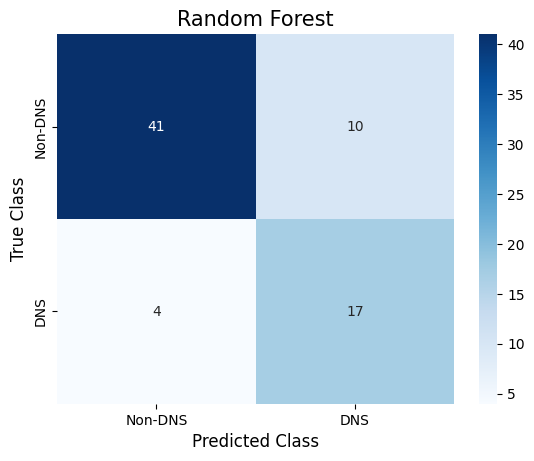

In [22]:
model_2 = RandomForestClassifier(
    n_estimators=best_params2['n_estimators'],
    max_depth=best_params2['max_depth'],
    min_samples_leaf=best_params2['min_samples_leaf'],
    min_samples_split=best_params2['min_samples_split'],
    max_features=best_params2['max_features'],
    random_state=0
)  ##  与决策树模型相似，尽管准确率和精确率相比调参前降低，但召回率得到提升

pipeline2 = make_pipeline(oversample_method, model_2)

evaluate_model(pipeline2, X_train, y_train, X_test, y_test, kf, 'Random Forest')

#### XGBoost，贝叶斯优化调参

In [23]:
def black_box_function3(n_estimators, learning_rate, max_depth, min_split_loss,
                        min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda):
    
    model = XGBClassifier(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        min_split_loss=float(min_split_loss),
        min_child_weight=float(min_child_weight),
        subsample=float(subsample),
        colsample_bytree=float(colsample_bytree),
        reg_alpha=float(reg_alpha),
        reg_lambda=float(reg_lambda),
        n_jobs=-1, seed=0
    )

    pipeline = make_pipeline(oversample_method, model)
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=kf)

    return cv_score.mean()

pbounds3 = {
    'n_estimators': (50, 500),
    'learning_rate': (0.01, 0.3),
    'max_depth': (1, 10),
    'min_split_loss': (0, 1),
    'min_child_weight': (0, 10),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1)
}

optimizer3 = BayesianOptimization(
    f=black_box_function3,
    pbounds=pbounds3,
    verbose=2,
    random_state=0
)

optimizer3.maximize(init_points=25,n_iter=75)

best_params3 = optimizer3.max['params']
best_params3['n_estimators'] = int(best_params3['n_estimators'])
best_params3['learning_rate'] = float('%.3g'%best_params3['learning_rate'])
best_params3['max_depth'] = int(best_params3['max_depth'])
best_params3['min_split_loss'] = float('%.3g'%best_params3['min_split_loss'])
best_params3['min_child_weight'] = float('%.3g'%best_params3['min_child_weight'])
best_params3['subsample'] = float('%.3g'%best_params3['subsample'])
best_params3['colsample_bytree'] = float('%.3g'%best_params3['colsample_bytree'])
best_params3['reg_alpha'] = float('%.3g'%best_params3['reg_alpha'])
best_params3['reg_lambda'] = float('%.3g'%best_params3['reg_lambda'])

print("Optimized parameters:",optimizer3.max)
print(best_params3)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.83      | 0.5939    | 0.2174    | 6.425     | 5.449     | 0.4237    | 340.7     | 0.4376    | 0.8918    | 0.9673    |
| 2         | 0.8267    | 0.4451    | 0.2396    | 5.76      | 5.68      | 0.9256    | 81.97     | 0.08713   | 0.02022   | 0.8494    |
| 3         | 0.8059    | 0.8003    | 0.2623    | 9.808     | 7.992     | 0.4615    | 401.2     | 0.1183    | 0.6399    | 0.229     |
| 4         | 0.8233    | 0.9502    | 0.1613    | 4.732     | 2.646     | 0.7742    | 255.3     | 0.5684    | 0.01879   | 0.6559    |
| 5         | 0.8128    | 0.6509    | 0.1889    | 9.494     | 6.818     | 0.3595    | 246.7     | 0.6976    | 0.06023   | 0.7001    |
| 6         | 0.8025    | 0.7036    | 0.07101   | 2.16      | 

#### 评估性能

XGBoost's results of 10-fold cross-validation are as follows: 
 [0.89655172 0.75862069 0.89655172 0.86206897 0.75862069 0.93103448
 0.75862069 0.93103448 0.92857143 0.85714286] 

XGBoost's mean accuracy of 10-fold cross-validation is 0.858
XGBoost's Matthews Correlation Coefficient is 0.513 

XGBoost's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        51
           1       0.59      0.76      0.67        21

    accuracy                           0.78        72
   macro avg       0.74      0.77      0.75        72
weighted avg       0.80      0.78      0.78        72



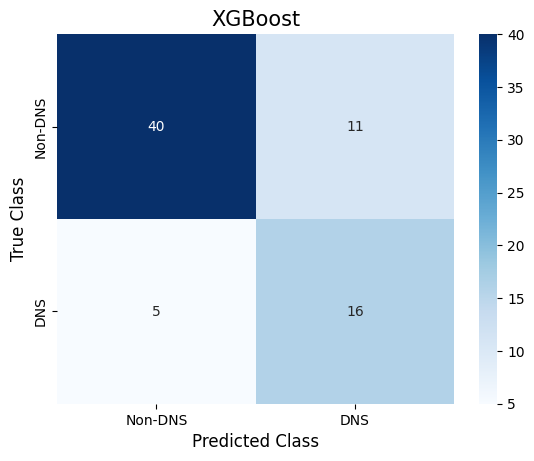

In [24]:
model_3 = XGBClassifier(
    n_estimators=best_params3['n_estimators'],
    learning_rate=best_params3['learning_rate'],
    max_depth=best_params3['max_depth'],
    min_split_loss=best_params3['min_split_loss'],
    min_child_weight=best_params3['min_child_weight'],
    colsample_bytree=best_params3['colsample_bytree'],
    subsample=best_params3['subsample'],
    reg_alpha=best_params3['reg_alpha'],
    reg_lambda=best_params3['reg_lambda'],
    seed=0
)  ##  尽管召回率没有得到提升，但准确率和精确率增长。这里存在过拟合之嫌，应该是使用 SMOTE 过采样策略造成的，在调整超参数时可以尝试缩小学习率的范围，例如设置 learning_rate 在 (0, 0.1)，可以缓解过拟合

pipeline3 = make_pipeline(oversample_method, model_3)

evaluate_model(pipeline3, X_train, y_train, X_test, y_test, kf, 'XGBoost')

#### LightGBM，贝叶斯优化调参

In [25]:
def black_box_function4(n_estimators, learning_rate, num_leaves, max_depth, min_child_samples,
                        subsample, colsample_bytree, reg_alpha, reg_lambda):
    
    model = LGBMClassifier(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        num_leaves=int(num_leaves),
        min_child_samples=int(min_child_samples),
        subsample=float(subsample),
        colsample_bytree=float(colsample_bytree),
        reg_alpha=float(reg_alpha),
        reg_lambda=float(reg_lambda),
        verbose=-1, n_jobs=-1, random_state=0
    )

    pipeline = make_pipeline(oversample_method, model)
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=kf)

    return cv_score.mean()

pbounds4 = {
    'n_estimators': (50, 500),
    'learning_rate': (0.01, 0.3),
    'max_depth': (1, 10),
    'num_leaves': (2, 1000),
    'min_child_samples': (1, 50),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1)
}

optimizer4 = BayesianOptimization(
    f=black_box_function4,
    pbounds=pbounds4,
    verbose=2,
    random_state=0
)

optimizer4.maximize(init_points=25, n_iter=75)

best_params4 = optimizer4.max['params']
best_params4['n_estimators'] = int(best_params4['n_estimators'])
best_params4['learning_rate'] = float('%.3g'%best_params4['learning_rate'])
best_params4['max_depth'] = int(best_params4['max_depth'])
best_params4['num_leaves'] = int(best_params4['num_leaves'])
best_params4['min_child_samples'] = int(best_params4['min_child_samples'])
best_params4['subsample'] = float('%.3g'%best_params4['subsample'])
best_params4['colsample_bytree'] = float('%.3g'%best_params4['colsample_bytree'])
best_params4['reg_alpha'] = float('%.3g'%best_params4['reg_alpha'])
best_params4['reg_lambda'] = float('%.3g'%best_params4['reg_lambda'])

print(optimizer4.max)
print(best_params4)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8369    | 0.5939    | 0.2174    | 6.425     | 27.7      | 240.6     | 646.6     | 0.4376    | 0.8918    | 0.9673    |
| 2         | 0.8234    | 0.4451    | 0.2396    | 5.76      | 28.83     | 466.5     | 72.89     | 0.08713   | 0.02022   | 0.8494    |
| 3         | 0.8368    | 0.8003    | 0.2623    | 9.808     | 40.16     | 257.7     | 781.0     | 0.1183    | 0.6399    | 0.229     |
| 4         | 0.8438    | 0.9502    | 0.1613    | 4.732     | 13.96     | 398.4     | 457.2     | 0.5684    | 0.01879   | 0.6559    |
| 5         | 0.8299    | 0.6509    | 0.1889    | 9.494     | 34.41     | 211.8     | 438.2     | 0.6976    | 0.06023   | 0.7001    |
| 6         | 0.8234    | 0.7036    | 0.07101   | 2.16      | 

#### 评估性能

LightGBM's results of 10-fold cross-validation are as follows: 
 [0.86206897 0.79310345 0.89655172 0.86206897 0.75862069 0.89655172
 0.82758621 0.93103448 0.92857143 0.75      ] 

LightGBM's mean accuracy of 10-fold cross-validation is 0.851
LightGBM's Matthews Correlation Coefficient is 0.529 

LightGBM's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        51
           1       0.67      0.67      0.67        21

    accuracy                           0.81        72
   macro avg       0.76      0.76      0.76        72
weighted avg       0.81      0.81      0.81        72



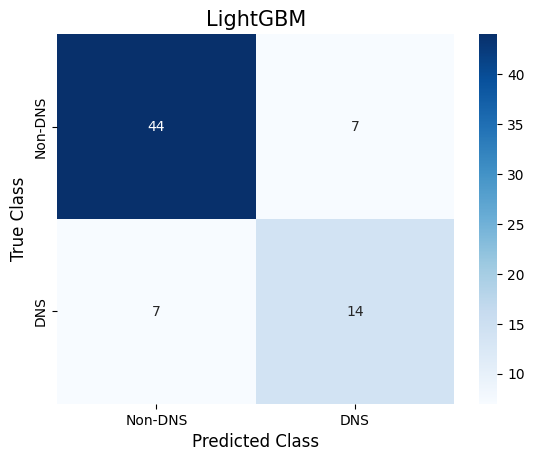

In [26]:
model_4 = LGBMClassifier(
    n_estimators=best_params4['n_estimators'],
    learning_rate=best_params4['learning_rate'],
    max_depth=best_params4['max_depth'],
    num_leaves=best_params4['num_leaves'],
    subsample=best_params4['subsample'],
    colsample_bytree=best_params4['colsample_bytree'],
    min_child_samples=best_params4['min_child_samples'],
    reg_alpha=best_params4['reg_alpha'],
    reg_lambda=best_params4['reg_lambda'],
    verbosity=-1,random_state=0
)  ##  召回率略有下降，但准确率有所上升，在可接受范围内

pipeline4 = make_pipeline(oversample_method, model_4)

evaluate_model(pipeline4, X_train, y_train, X_test, y_test, kf, 'LightGBM')

#### SMOTE-Random Forest 模型在具有高准确率的同时，还具有最高的召回率，能够很好的预测 DNS 样本，因此选择它作为我们的最终模型
#### 我们还使用 SHAP 来近似 SMOTE-Random Forest 模型的输出结果：SHAP 蜂群图中，每个特征按它们平均绝对 SHAP 值的大小从上至下排列；图中的每一个点代表一个样本；x 轴表示计算出的 SHAP 值，其中正轴表示正类（即发展为 DNS）的预测，负轴指示为负类（即未发展成 DNS）的预测。

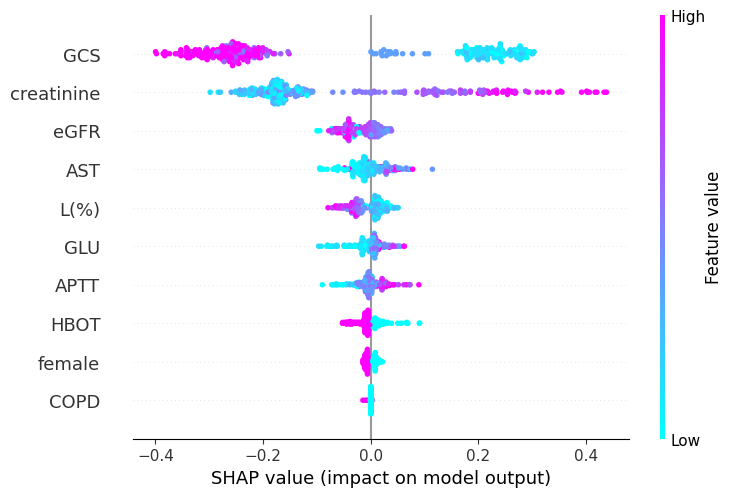

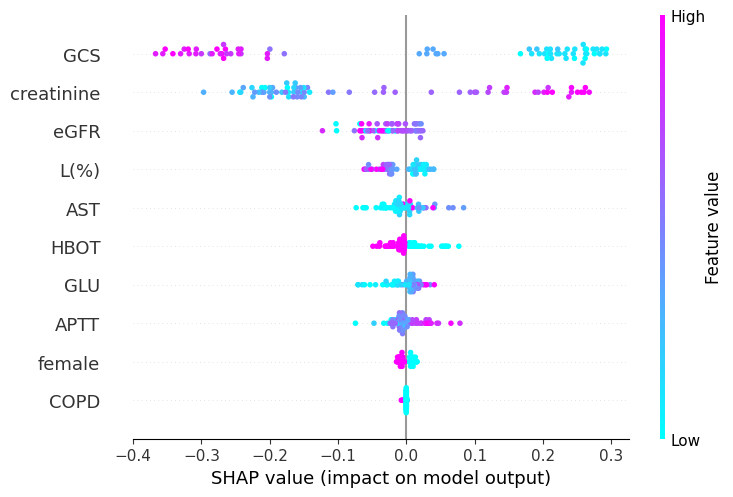

In [27]:
explainer = shap.TreeExplainer(model_2)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

plt.figure()
shap.plots.beeswarm(shap_values_train[:, :, 1], color=plt.get_cmap("cool"), show=False)
plt.savefig('SHAP训练集.png', dpi=300, bbox_inches='tight')

plt.figure()
shap.plots.beeswarm(shap_values_test[:, :, 1], color=plt.get_cmap("cool"), show=False)
plt.savefig('SHAP测试集.png', dpi=300, bbox_inches='tight')

plt.show()

#### 保存 SMOTE 模型

In [28]:
model_s = [pipeline1, pipeline2, pipeline3, pipeline4]
filenames = [
            'model_1_SMOTE_filename.pkl',
            'model_2_SMOTE_filename.pkl',
            'model_3_SMOTE_filename.pkl',
            'model_4_SMOTE_filename.pkl'
]

for model, filename in zip(model_s, filenames):

    with open(filename, 'wb') as file:
        pickle.dump(model, file)

### <mark>**以上为使用 SMOTE 过采样策略的建模过程，使用 ADASYN 或 ROS 过采样策略建模的步骤与之相同，故不再展示**</mark>

---

### **以下为三个能够最好预测 DNS 样本的模型：**

#### 导入最佳模型

In [29]:
filenames = [
            'model_1_SMOTE_filename.pkl',  ##  SMOTE-Decision Tree
            'model_2_SMOTE_filename.pkl',  ##  SMOTE-Random Forest
            'model_2_ADASYN_filename.pkl'  ##  ADASYN-Random Forest
]

modelnames = ['SMOTE-Decision Tree', 'SMOTE-Random Forest', 'ADASYN-Random Forest']
loaded_models = []

for filename in filenames:

    with open(filename, 'rb') as file:
        model = pickle.load(file)
        loaded_models.append(model)

#### 查看性能

SMOTE-Decision Tree's results of 10-fold cross-validation are as follows: 
 [0.82758621 0.75862069 0.82758621 0.86206897 0.68965517 0.86206897
 0.75862069 0.79310345 0.85714286 0.82142857] 

SMOTE-Decision Tree's mean accuracy of 10-fold cross-validation is 0.806
SMOTE-Decision Tree's Matthews Correlation Coefficient is 0.491 

SMOTE-Decision Tree's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80        51
           1       0.55      0.81      0.65        21

    accuracy                           0.75        72
   macro avg       0.73      0.77      0.73        72
weighted avg       0.80      0.75      0.76        72



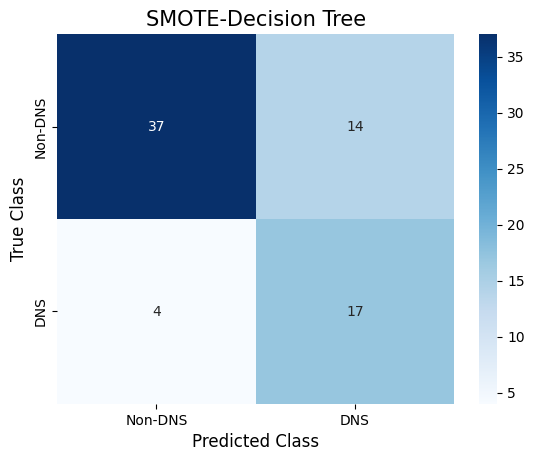

SMOTE-Random Forest's results of 10-fold cross-validation are as follows: 
 [0.82758621 0.82758621 0.89655172 0.86206897 0.79310345 0.89655172
 0.79310345 0.82758621 0.89285714 0.82142857] 

SMOTE-Random Forest's mean accuracy of 10-fold cross-validation is 0.844
SMOTE-Random Forest's Matthews Correlation Coefficient is 0.576 

SMOTE-Random Forest's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        51
           1       0.63      0.81      0.71        21

    accuracy                           0.81        72
   macro avg       0.77      0.81      0.78        72
weighted avg       0.83      0.81      0.81        72



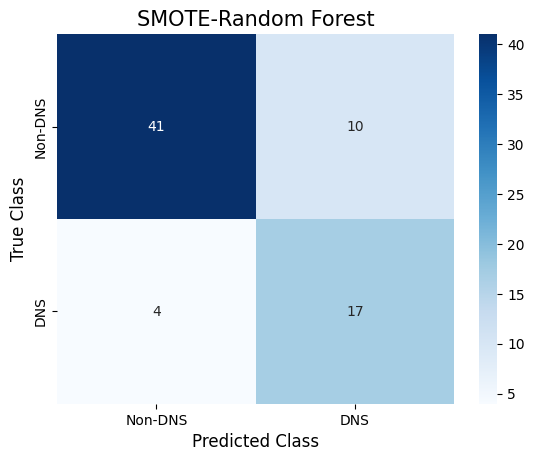

ADASYN-Random Forest's results of 10-fold cross-validation are as follows: 
 [0.82758621 0.79310345 0.79310345 0.86206897 0.72413793 0.93103448
 0.82758621 0.89655172 0.89285714 0.78571429] 

ADASYN-Random Forest's mean accuracy of 10-fold cross-validation is 0.833
ADASYN-Random Forest's Matthews Correlation Coefficient is 0.576 

ADASYN-Random Forest's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        51
           1       0.63      0.81      0.71        21

    accuracy                           0.81        72
   macro avg       0.77      0.81      0.78        72
weighted avg       0.83      0.81      0.81        72



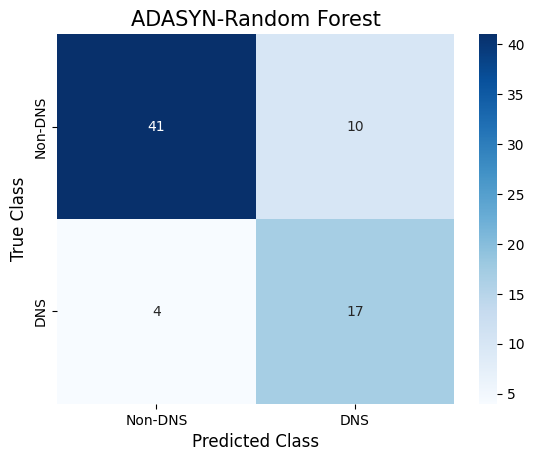

In [31]:
for ppl, name in zip(loaded_models, modelnames):
    
    print('='*75)
    evaluate_model(ppl, X_train, y_train, X_test, y_test, kf, name)

#### ROC 曲线

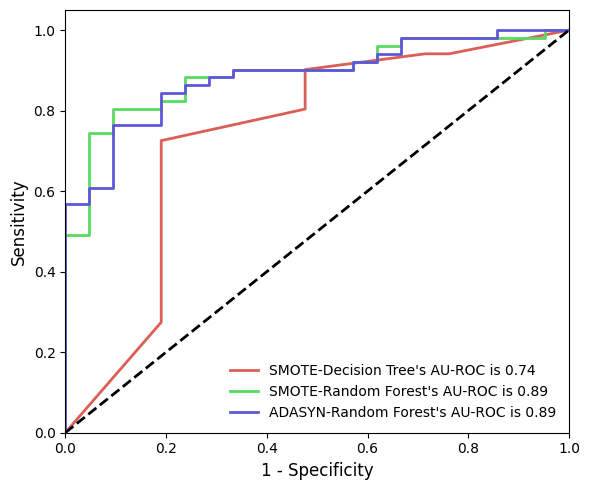

In [32]:
color_s = sns.color_palette('hls', 3)
roc_fpr, roc_tpr, roc_labels = [], [], []

plt.figure(figsize=(6, 5))

for model, color, name in zip(loaded_models, color_s, modelnames):
    
    y_proba = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 0], pos_label=0)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name}\'s AU-ROC is {roc_auc:.2g}', color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity', fontsize=12)
plt.ylabel('Sensitivity', fontsize=12)
plt.legend(loc='best', frameon=False, prop = {'size': 10})

plt.tight_layout()
plt.savefig('ROC.png', dpi=300)

plt.show()

#### 阈值校准曲线，我们以F1度量作为衡量指标

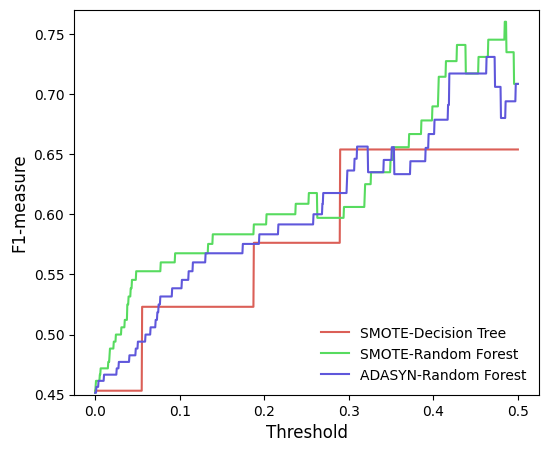

In [33]:
thresholds = np.linspace(0, 0.5, 1000)  ##  阈值设置在 0 到 0.5 之间，等距取 1000 个点
f1_scores = []
plt.figure(figsize=(6, 5))

for model, name, color in zip(loaded_models, modelnames, color_s):

    y_proba = model.predict_proba(X_test)[:, 1]
    f1_at_thresholds = []
    
    for thresh in thresholds:

        y_pred = (y_proba>thresh).astype(int)
        f1 = f1_score(y_test, y_pred)
        f1_at_thresholds.append(f1)

    f1_scores.append(f1_at_thresholds)
    
    plt.plot(thresholds, f1_at_thresholds, label=f'{name}', color=color)  

plt.xlabel('Threshold', fontsize=12)  
plt.ylabel('F1-measure', fontsize=12)
plt.legend(loc='lower right', frameon=False, prop = {'size': 10})
plt.ylim(0.45, 0.77)
plt.savefig('阈值.png', dpi=300, bbox_inches='tight')
plt.show()

#### 很显然，由阈值校准曲线可知，阈值约为 0.485 时，SMOTE-Random Forest 模型能够达到最佳性能，如下所示：

SMOTE-Random Forest's accuracy is 0.833 (test set)
              precision    recall  f1-score   support

           0       0.95      0.80      0.87        51
           1       0.66      0.90      0.76        21

    accuracy                           0.83        72
   macro avg       0.80      0.85      0.82        72
weighted avg       0.87      0.83      0.84        72

SMOTE-Random Forest's matthews corrcoef score is 0.657


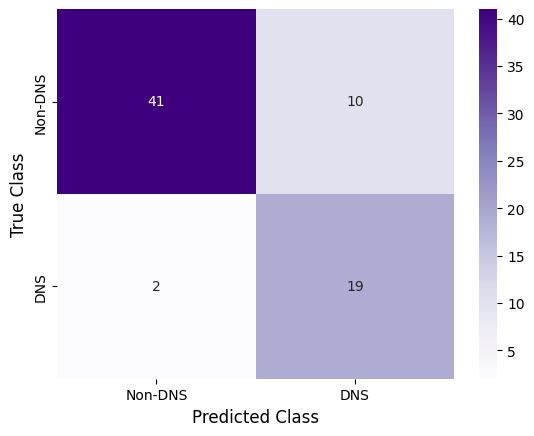

In [34]:
names = ['Non-DNS', 'DNS']

y_proba = loaded_models[1].predict_proba(X_test)[:, 1]
y_pred = (y_proba>0.485).astype(int)
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(cm, index=names, columns=names)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
mc = matthews_corrcoef(y_test, y_pred)

print(f'{modelnames[1]}\'s accuracy is {accuracy:.3g} (test set)')
print(report)
print(f'{modelnames[1]}\'s matthews corrcoef score is {mc:.3g}')

plt.figure()
sns.heatmap(conf_matrix, annot=True, annot_kws={"size":10}, cmap="Purples")
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.savefig('阈值调整后混淆矩阵.png', dpi=300, bbox_inches='tight')

plt.show()